# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.



## Introducción

El presente proyecto tendrá como objetivo analizar el comportamiento de los clientes de Megaline y evaluar la rentabilidad de sus dos planes principales: **Surf** y **Ultimate**. Para ello se integrarán y procesarán los datos de usuarios, llamadas, mensajes, navegación en internet y condiciones de los planes en un único Data Frame (`master_df`).  

El análisis tomará en cuenta las reglas de facturación y redondeo establecidas por la compañía, y se apoyará en estadísticas descriptivas y visualizaciones. El enfoque se dirigirá a tres categorías de uso —llamadas, SMS y datos móviles— con el propósito de identificar patrones de consumo y diferencias en los ingresos generados por plan y en particular analizaremos si hay alguna diferencia de comportamiento en la región de NY-NJ. Estas diferencias las confirmaremos con pruebas de hipótesis estadísticas.

En última instancia, el estudio buscará proporcionar información sólida que permita a la empresa orientar sus decisiones estratégicas, en particular la asignación de recursos de publicidad.

### Descripción de las tarifas

**Nota:** Megaline redondea los segundos a minutos y los megabytes a gigabytes.  
Para las llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto.  

Para el tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba.  
Por ejemplo, si alguien usa 1025 MB en un mes, se le cobrarán 2 GB.

---

### Diccionario de datos

Hay **cinco tablas** diferentes:

#### `users` — datos sobre los usuarios
- `user_id`: identificador único del usuario  
- `first_name`: nombre del usuario  
- `last_name`: apellido del usuario  
- `age`: edad (años)  
- `reg_date`: fecha de suscripción *(dd, mm, aa)*  
- `churn_date`: fecha en que el usuario dejó de usar el servicio *(NaN si sigue activo)*  
- `city`: ciudad de residencia  
- `plan`: nombre de la tarifa  

#### `calls` — datos sobre las llamadas
- `id`: identificador único de la llamada  
- `call_date`: fecha de la llamada  
- `duration`: duración (minutos)  
- `user_id`: identificador del usuario que realiza la llamada  

#### `messages` — datos sobre los SMS
- `id`: identificador único del SMS  
- `message_date`: fecha del SMS  
- `user_id`: identificador del usuario que envía el SMS  

#### `internet` — datos sobre las sesiones web
- `id`: identificador único de la sesión  
- `mb_used`: datos usados en la sesión (MB)  
- `session_date`: fecha de la sesión  
- `user_id`: identificador del usuario  

#### `plans` — datos sobre las tarifas
- `plan_name`: nombre de la tarifa  
- `usd_monthly_fee`: pago mensual (USD)  
- `minutes_included`: minutos incluidos al mes  
- `messages_included`: SMS incluidos al mes  
- `mb_per_month_included`: datos incluidos (MB)  
- `usd_per_minute`: costo por minuto extra  
- `usd_per_message`: costo por SMS extra  
- `usd_per_gb`: costo por GB extra *(1 GB = 1024 MB)*

Queremos que nuestro Data Frame final contenga el **consumo mensual total** de cada usuario. Para ello limpiaremos y transformaremos los datos de cada tabla apropiadamente, de manera que finalmente podamos extraer y sintetizar la información necesaria.
Para hacer más sencillo este proceso en cada tabla que tenga registros de consumo, i.e. `calls`, `messages` e `ìnternet`, agregaremos **una columna que tenga únicamente el mes** correspondiente a cada registro.


## Inicialización

In [1]:
# Cargar todas las librerías
import numpy as np
import pandas as pd


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')

## Preparar los datos

Los datos para este proyecto se dividen en varias tablas. Exploraremos cada una para tener una comprensión inicial de los datos y hacer las correcciones requeridas en cada tabla.

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Vemos que este data frame tiene toda la información sobre los dos plnaes de interés: los mensajes, minutos y mb para navegar que incluye mensualmente, y las tarifas por uso adicional. Toda la información tiene un tipo de dato adecuado, la información está completa y sin duplicados.

Como se nos mencionó que el cobro de las tarifas se redondea por gigabytes y no por megabytes, sería útil **añadir una columna que contenga la información en GB**.

#### Corregir datos

No hace falta corregir nada, ya que no hay valores ausentes ni duplicados y los tipos de datos son correctos.

#### Enriquecer los datos

Podemos agregar una columna adicional que contenga los **gigabytes** incluidos por mes.

In [5]:
# Crear columna nueva con el número de gigas
plans['gb_included'] = plans['mb_per_month_included'] / 1024
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


In [6]:
# Podemos convertir el tipo de dato de la nueva columna a entero
plans['gb_included'] = plans['gb_included'].astype(int)
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
191,1191,Zack,Waters,75,"St. Louis, MO-IL MSA",2018-01-21,ultimate,2018-11-30
181,1181,Ron,Kaufman,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-13,surf,NaN
393,1393,Wilfredo,Rosa,44,"Knoxville, TN MSA",2018-10-29,surf,NaN
254,1254,Billy,Webb,49,"Detroit-Warren-Dearborn, MI MSA",2018-08-03,surf,NaN
379,1379,Jarrett,Spencer,34,"Grand Rapids-Kentwood, MI MSA",2018-10-18,surf,NaN


In [9]:
# Verificar que no hay duplicados (por nombre completo)
users[users[['first_name', 'last_name']].apply(lambda x: x.str.lower()).duplicated()]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date


Este DataFrame contiene los datos de cada usuario, incluyendo el plan que contratan y sus fechas de registro y terminación. Notamos que a las dos columnas que tienen fechas (`reg_date`y `churn_date`) se les puede **cambiar el tipo de dato a datetime**. 

Además `churn_date` es la única columna con valores ausentes. Sin embargo estos valores ausentes están bien justificados porque corresponden a los usuarios que no han dejado de usar su plan.

Finalmente verificamos que no hay registros duplicados.

### Corregir los datos

Cambiamos el tipo de dato de las dos columnas que tienen fechas.

In [10]:
# Cambiar columnas con fechas a datetime
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

No hace falta añadir datos a este data frame. 

In [11]:
# Muestra de los datos modificados
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
86,1086,Adena,Macias,36,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-13,ultimate,NaT
99,1099,Shavon,Banks,48,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-26,surf,NaT
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaT
385,1385,Nohemi,Erickson,52,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-19,surf,NaT
87,1087,Lenard,Atkinson,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-11-18,surf,NaT


## Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Imprime una muestra de datos para las llamadas
calls.tail()

,id,user_id,call_date,duration
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37
137734,1499_203,1499,2018-12-29,13.86


In [14]:
# Verificar que no hay duplicados
calls[calls['id'].duplicated()]

,id,user_id,call_date,duration


De inicio observamos que no hay datos ausentes ni duplicados y que `call_date`se puede **cambiar a datetime**. Adicionalmente esto último nos permítirá extraer facilmente el mes de cada registro en una nueva columna.

Además, recordemos que se mencionó que para cada llamada se **redondea la duración en minutos hacia arriba**. Vemos que actualmente el dataframe contiene minutos con decimales, así que podemos aplicar la operación techo (`np.ceil()`) en la columna `duration`. La conversión de tipo float a tipo int en esta columna la llevaremos a cabo más adelante.


### Corregir los datos

Actualizamos el tipo de dato de las fechas a datetime y redondeamos hacia arriba la duración de las llamadas en minutos.

In [15]:
# Cambiar las fechas a datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])

# Redondear la duración en minutos
calls['duration'] = np.ceil(calls['duration'])

# Cambiar la duración a int?????????

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

Dado que finalmente queremos hacer un análisis de los consumos mensuales, agregamos la columna en la que extraemos sólamente el mes de cada registro.

In [16]:
# Agregar columna con el mes
calls['month'] = calls['call_date'].dt.month

calls.tail()

,id,user_id,call_date,duration,month
137730,1499_199,1499,2018-11-21,9.0,11
137731,1499_200,1499,2018-10-20,11.0,10
137732,1499_201,1499,2018-09-21,9.0,9
137733,1499_202,1499,2018-10-10,1.0,10
137734,1499_203,1499,2018-12-29,14.0,12


## Mensajes

In [17]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [18]:
# Imprime una muestra de datos para los mensajes
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [19]:
# Verificar que no hay duplicados
messages[messages['id'].duplicated()]


,id,user_id,message_date


Aquí de nuevo vemos una fecha (`message_date`) que se puede actualizar a tipo datetime. Los demás elementos del dataframe cumplen con lo esperado.

### Corregir los datos

Actualizamos el tipo de dato de las fechas a datetime.

In [20]:
# Cambiar las fechas a datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

### Enriquecer los datos

Igual que en la sección anterior, gracias a que tenemos las fechas en tipo datetime, podemos agregar una columna en la que extraemos sólamente el mes de cada registro.

In [21]:
# Agregar columna con el mes
messages['month'] = messages['message_date'].dt.month

messages.tail()

,id,user_id,message_date,month
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12
76050,1497_613,1497,2018-12-23,12


## Internet

In [22]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [23]:
# Imprime una muestra de datos para el tráfico de internet
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Una vez más hay que actualizar la columna con fechas (`session_date`) **a tipo datetime**. 

Además recordemos que al final nos interesa el número de gigabytes y no de megabytes, por lo que es conveniente **agregar una columna** con esta inforación, como hicimos en `tarifas`. Y recordemos que en este caso no debemos redondear el número de GB usados todavía, ya que estos se redondean hasta hacer el recuento mensual.

Los demás elementos del DataFrame cumplen con lo esperado.

### Corregir los datos

Actualizamos el tipo de dato de las fechas a datetime.

In [24]:
# Cambiar las fechas a datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

Como en las dos tablas anteriores, agregamos una columna en la que extraemos sólamente el mes de cada registro.

Adicionalmente agregamos una columna con los GB usados.

In [25]:
# Agregar columna con el mes
internet['month'] = internet['session_date'].dt.month

# Agregar columna de GB
internet['gb_used'] = internet['mb_used'] / 1024

internet.head()

,id,user_id,session_date,mb_used,month,gb_used
0,1000_13,1000,2018-12-29,89.86,12,0.087754
1,1000_204,1000,2018-12-31,0.00,12,0.000000
2,1000_379,1000,2018-12-28,660.40,12,0.644922
3,1000_413,1000,2018-12-26,270.99,12,0.264639
4,1000_442,1000,2018-12-27,880.22,12,0.859590


## Estudiar las condiciones de las tarifas

Debemos entender cómo funcionan las tarifas, es decir cómo se les cobra a los usuarios en función de su plan de suscripción. Imprimimos aquí de nuevo la información de la tarifa para ver una vez más sus condiciones.

In [26]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Agregar datos por usuario

Ahora que los datos están limpios,nos interesa sintetizar los datos en cada categoría de consume por usuario y por periodo (mes) para que solo haya un registro por usuario y por periodo. 
Para ello haremos una agregación con `.groupby()` por usuario y mes (usando la columna `month`que creamos) para cada una de las tablas relevantes. 

Posteriormente juntaremos toda la información en una única tabla para facilitar el análisis.

In [27]:
# Calcula el número de llamadas hechas por cada usuario al mes
# y la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

calls_monthly = calls.groupby(['user_id', 'month']).agg(
    total_calls = ('id', 'count'),
    total_mins = ('duration', 'sum')
)
calls_monthly.reset_index(inplace=True)

In [28]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

#Completamos esta tarea en la celda anterior
calls_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      2258 non-null   int64  
 1   month        2258 non-null   int64  
 2   total_calls  2258 non-null   int64  
 3   total_mins   2258 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 70.7 KB


In [29]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

msg_monthly = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
msg_monthly.rename(columns={'id':'total_msgs'}, inplace=True)
msg_monthly

,user_id,month,total_msgs
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [30]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

internet_monthly = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index()
internet_monthly 

,user_id,month,gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605
...,...,...,...
2272,1498,12,22.595400
2273,1499,9,12.680430
2274,1499,10,19.035576
2275,1499,11,16.419756


## Juntar datos mensuales y calcular tarifa total

Ahora juntemos todos los datos agregados en un DataFrame, de manera que haya un registro único con lo que consumió cada usuario durante un mes determinado.

Ya tenemos la información de las llamadas junta, así que usando un par de veces el método `.merge()` podemos juntar la información de los mensajes y la navegación.

In [31]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
buffer_df = calls_monthly.merge(msg_monthly, on=['user_id','month'], how='outer')

buffer_df = buffer_df.merge(internet_monthly, on=['user_id','month'], how='outer')
buffer_df

,user_id,month,total_calls,total_mins,total_msgs,gb_used
0,1000,12,16.0,124.0,11.0,1.856904
1,1001,8,27.0,182.0,30.0,6.756982
2,1001,9,49.0,315.0,44.0,13.002754
3,1001,10,65.0,393.0,53.0,21.807119
4,1001,11,64.0,426.0,36.0,18.070605
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,12.734287
2289,1361,5,NaN,NaN,2.0,1.484072
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,0.227705


In [32]:
buffer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      2293 non-null   int64  
 1   month        2293 non-null   int64  
 2   total_calls  2258 non-null   float64
 3   total_mins   2258 non-null   float64
 4   total_msgs   1806 non-null   float64
 5   gb_used      2277 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 125.4 KB



Al realizar un **full (outer) join**, se generaron valores ausentes para los meses en los que un usuario no presentó consumo en alguna de las categorías. Como consecuencia adicional, en las columnas afectadas, pandas convierte los tipos de datos originalmente `int` a `float`.  

Podemos corregir estos inconvenientes reemplazando los valores ausentes por cero, ya que sabemos que en esas categorías no hay valores ausentes previos, y sí nos interesa estudiar el comportamiento de todos los usuarios, no sólo de aquellos que tuvieron consumos en todas las categorías necesariamente. Finalmente regresando las columnas a tipo `int`.  

Además podemos, ahora sí, **redondear el consumo de gigas mensual** para calcular la **tarifa final** correctamente.

 

In [33]:
# Remplazar valores ausentes por ceros y cambiar a tipo int
for column in ['total_calls', 'total_mins', 'total_msgs']:
    buffer_df[column] = buffer_df[column].fillna(0).astype(int)

buffer_df['gb_used'].fillna(0, inplace=True) # Mantenemos la columna de gygas sin redondear

# Agregamos columna con gygas redondeados
buffer_df['total_gb'] = np.ceil(buffer_df['gb_used']).astype(int)
buffer_df

,user_id,month,total_calls,total_mins,total_msgs,gb_used,total_gb
0,1000,12,16,124,11,1.856904,2
1,1001,8,27,182,30,6.756982,7
2,1001,9,49,315,44,13.002754,14
3,1001,10,65,393,53,21.807119,22
4,1001,11,64,426,36,18.070605,19
...,...,...,...,...,...,...,...
2288,1349,12,0,0,61,12.734287,13
2289,1361,5,0,0,2,1.484072,2
2290,1482,10,0,0,2,0.000000,0
2291,1108,12,0,0,0,0.227705,1


Finalmente añadimos la información del plan que contrató cada usario. 
Para ello hacemos primero un merge con la tabla `users`, incluyendo sólo la información de interés: el plan y la ciudad (para un análisis posterior).
Esta vez usamos un left join, ya que no nos interesan los usuarios que no han hecho ningún consumo.

Teniendo una columna con el plan en nuestro DataFrame, podemos finalmente hacer otro merge con la tabla `plans` y tener la información completa para calcular el cargo total por periodo de cada usuario.

In [34]:
# Añade la información del plan de cada usuario (TABLA FINAL)
master_df = buffer_df.merge(users[['user_id', 'plan', 'city']], on='user_id', how='left')

# Añade la información de la tarifa
master_df = master_df.merge(plans, left_on='plan', right_on='plan_name')

# Borrar columna repetida
master_df.drop(columns='plan_name', inplace=True)

Finalmente calculamos el cargo mensual por usuario con la siguiente fórmula:

$$
\begin{aligned}
\text{total\_charge} = &\ \text{usd\_monthly\_pay} \\
&+ \max(0, \text{total\_mins} - \text{minutes\_included}) \times \text{usd\_per\_minute} \\
&+ \max(0, \text{total\_msgs} - \text{messages\_included}) \times \text{usd\_per\_message} \\
&+ \max(0, \text{total\_gb} - \text{gb\_included}) \times \text{usd\_per\_gb}
\end{aligned}
$$

En vez de usar la función `max()`, en pandas podemos usar el método `.clip(lower=0)` para objetos Series.

In [35]:
# Calcula el ingreso mensual para cada usuario

# Calcular excedente por categoría
overage_mins = (master_df['total_mins'] - master_df['minutes_included']).clip(lower=0)
overage_msgs = (master_df['total_msgs'] - master_df['messages_included']).clip(lower=0)
overage_gb   = (master_df['total_gb'] - master_df['gb_included']).clip(lower=0)

# Calcular el cargo total
master_df['total_charge'] = (
    master_df['usd_monthly_pay'] 
    + overage_mins * master_df['usd_per_minute']
    + overage_msgs * master_df['usd_per_message']
    + overage_gb   * master_df['usd_per_gb']
)

master_df

,user_id,month,total_calls,total_mins,total_msgs,gb_used,total_gb,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_included,total_charge
0,1000,12,16,124,11,1.856904,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01,30,70.00
1,1006,11,2,10,15,2.019893,3,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,30,70.00
2,1006,12,9,59,139,31.366035,32,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,30,84.00
3,1008,10,71,476,21,16.706045,17,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,30,70.00
4,1008,11,63,446,37,23.121797,24,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,30,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1194,12,0,0,56,30.359854,31,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA",50,15360,500,20,10,0.03,0.03,15,180.18
2289,1349,10,0,0,76,12.786670,13,surf,"Boston-Cambridge-Newton, MA-NH MSA",50,15360,500,20,10,0.03,0.03,15,20.78
2290,1349,11,0,0,72,16.726816,17,surf,"Boston-Cambridge-Newton, MA-NH MSA",50,15360,500,20,10,0.03,0.03,15,40.66
2291,1349,12,0,0,61,12.734287,13,surf,"Boston-Cambridge-Newton, MA-NH MSA",50,15360,500,20,10,0.03,0.03,15,20.33


Ya que hemos calculado el cargo mensual total, no es necesario que sigamos manteniendo la información detallada de las tarifas en la tabla.

In [36]:
# Quitar la información general de las tarifas 
master_df.drop(columns=['messages_included', 'mb_per_month_included',
                        'minutes_included', 'usd_monthly_pay',
                        'usd_per_gb', 'usd_per_message',
                        'usd_per_minute', 'gb_included'],
              inplace=True)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       2293 non-null   int64  
 1   month         2293 non-null   int64  
 2   total_calls   2293 non-null   int64  
 3   total_mins    2293 non-null   int64  
 4   total_msgs    2293 non-null   int64  
 5   gb_used       2293 non-null   float64
 6   total_gb      2293 non-null   int64  
 7   plan          2293 non-null   object 
 8   city          2293 non-null   object 
 9   total_charge  2293 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 197.1+ KB


# Estudia el comportamiento de usuario

Calcularemos las estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Aunado a gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, dividimos todas las estadísticas y gráficas por tarifa.


In [37]:
# Importamos librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt


Para tener más contexto del siguiente análisis, observemos cómo la cantidad de usuarios por mes fue aumentando para ambos planes.

In [38]:
master_df

,user_id,month,total_calls,total_mins,total_msgs,gb_used,total_gb,plan,city,total_charge
0,1000,12,16,124,11,1.856904,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1006,11,2,10,15,2.019893,3,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",70.00
2,1006,12,9,59,139,31.366035,32,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",84.00
3,1008,10,71,476,21,16.706045,17,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",70.00
4,1008,11,63,446,37,23.121797,24,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",70.00
...,...,...,...,...,...,...,...,...,...,...
2288,1194,12,0,0,56,30.359854,31,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA",180.18
2289,1349,10,0,0,76,12.786670,13,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.78
2290,1349,11,0,0,72,16.726816,17,surf,"Boston-Cambridge-Newton, MA-NH MSA",40.66
2291,1349,12,0,0,61,12.734287,13,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.33


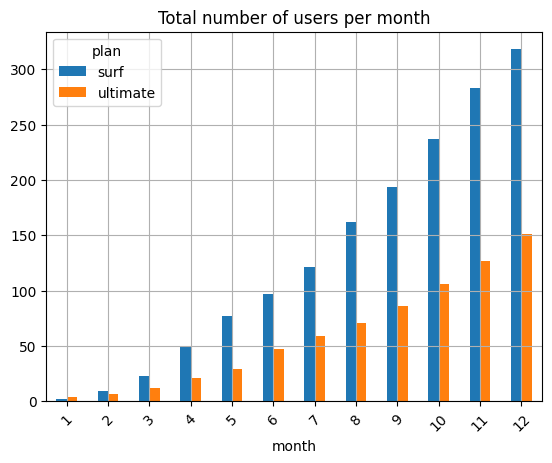

month  plan    
1      surf         2
       ultimate     4
2      surf         9
       ultimate     7
3      surf        23
       ultimate    12
Name: user_id, dtype: int64

In [39]:
# Mostrar el número de usuarios por mes
master_df.pivot_table(index='month', columns='plan', values='user_id', aggfunc='count').plot(kind='bar', rot=45)
plt.title('Total number of users per month')
plt.grid(True)
plt.show()

# Imprimir los primeros valores
master_df.groupby(['month', 'plan'])['user_id'].count().head(6)


Podemos observar cualitativamente que el pan **Surf** creció más en popularidad que **Ultimate** a lo largo del año.

### Llamadas

In [40]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. 
calls_monthly = master_df.groupby(['plan','month']).agg(
    total_calls=('total_calls', 'sum'),
    total_mins=('total_mins', 'sum')
).reset_index()

# Calcular la duración promedio en una nueva columna
calls_monthly['mean_duration'] = calls_monthly['total_mins'] / calls_monthly['total_calls']
calls_monthly

,plan,month,total_calls,total_mins,mean_duration
0,surf,1,60,406,6.766667
1,surf,2,366,2673,7.303279
2,surf,3,1068,7590,7.106742
3,surf,4,2444,17577,7.191899
4,surf,5,4289,30768,7.173700
5,surf,6,5769,41836,7.251863
6,surf,7,7642,54448,7.124836
7,surf,8,9325,66438,7.124718
8,surf,9,11273,80360,7.128537
9,surf,10,14303,101846,7.120604


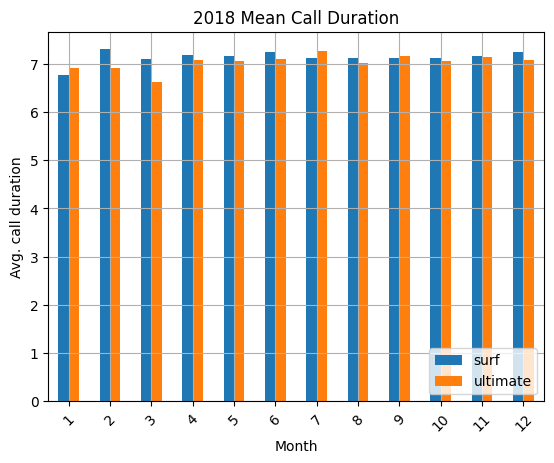

In [41]:
# Traza un gráfico de barras para visualizarla.

# Separamos en una columna para cada plan y graficamos
# Duración promedio de llamadas
calls_monthly.pivot(index='month', columns='plan', values='mean_duration').plot(kind='bar', rot=45)

plt.title('2018 Mean Call Duration')
plt.ylabel('Avg. call duration')
plt.xlabel('Month')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Número de llamadas promedio
#master_df.pivot_table(index='month', columns='plan', values='total_calls', aggfunc='mean').plot(kind='bar', rot=45)


Observaciones:
- La duración promedio de ambos planes es cercana a 7 minutos durante todo el año. 
- La mayoría de los meses duran más las llamadas de los usuarios de *surf* excepto en enero, agosto y octubre.
- La diferencia entre promedios no es muy significativa, de menos de un minuto en todos los casos. Las mayores diferencias se dieron en febrero y marzo.

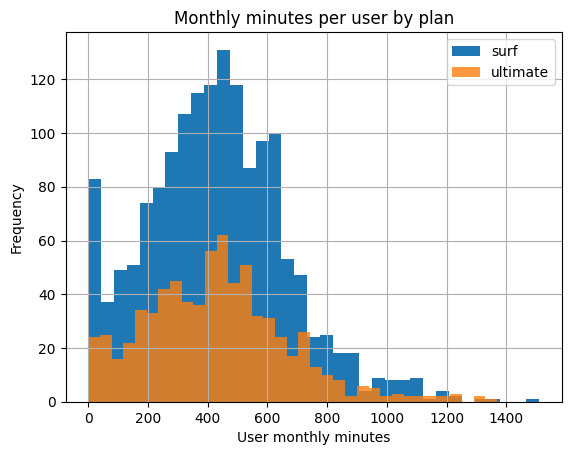

In [42]:
# Comparar la cantidad de minutos utilizados por usuario por plan
master_df.query("plan=='surf'")['total_mins'].hist(bins=35, legend=True)
master_df.query("plan=='ultimate'")['total_mins'].hist(bins=35, alpha=0.8, legend=True)

plt.legend(['surf', 'ultimate'])
plt.title('Monthly minutes per user by plan')
plt.xlabel('User monthly minutes')
plt.ylabel('Frequency')
plt.show()


Vemos que el comportamiento de consumo de minutos de los usuarios de ambos planes es bastante similar. Calculemos los valores de posicion y variabilidad para verificar esto.

In [43]:
# Calcula la media y la varianza de la duración mensual de llamadas.

print('surf:')
print(master_df.query("plan=='surf'")['total_mins'].describe()[0:3].to_string())
print('median\t', master_df.query("plan=='surf'")['total_mins'].median())
print('var\t', master_df.query("plan=='surf'")['total_mins'].var())

print('\nultimate:')
print(master_df.query("plan=='ultimate'")['total_mins'].describe()[0:3].to_string())
print('median\t', master_df.query("plan=='ultimate'")['total_mins'].median())
print('var\t', master_df.query("plan=='ultimate'")['total_mins'].var())

surf:
count    1573.000000
mean      428.749523
std       234.453150
median	 425.0
var	 54968.27946065038

ultimate:
count    720.000000
mean     430.450000
std      240.508762
median	 424.0
var	 57844.46481223922


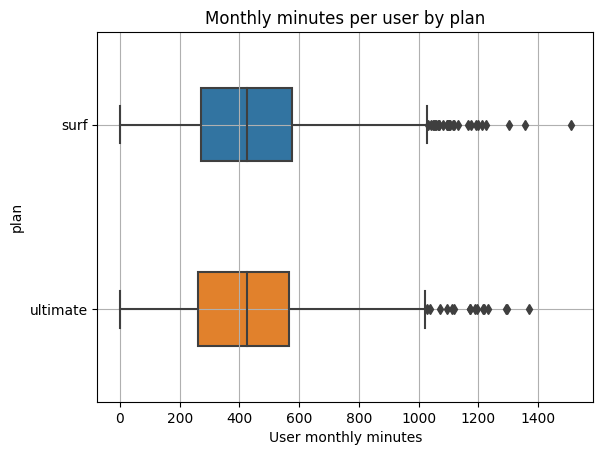

In [44]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(data=master_df, y='plan', x='total_mins', width=0.4, order=['surf', 'ultimate'])
plt.grid(True)
plt.title('Monthly minutes per user by plan')
plt.xlabel('User monthly minutes')
plt.show()


In [45]:
# Imprimir valores atípicos más altos
master_df[['user_id','plan', 'total_mins']].sort_values(by='total_mins', ascending=False).head()

,user_id,plan,total_mins
1567,1267,surf,1510
435,1329,ultimate,1369
1918,1365,surf,1357
1748,1324,surf,1304
499,1382,ultimate,1295


El análisis de la distribución de minutos muestra un **comportamiento de uso bastante similar entre usuarios de ambos planes**, con un promedio cercano a 430 minutos mensuales y una desviación estándar cercana a 240 minutos.

Sin embargo, las implicaciones para la empresa difieren sustancialmente según el plan:
- Ultimate: en su mayoría no alcanzan el límite de 1000 minutos incluidos. Como consecuencia, generan pocos ingresos adicionales por cargos extra.
- Surf: consumen prácticamente la totalidad de los 500 minutos incluidos, y **un porcentaje significativo incurre en cargos por excedente**, los cuales además son más rentables para la empresa dado que el costo unitario es mayor (0.03 USD vs. 0.01 USD en Ultimate).

También se observa la presencia de **valores atípicos** similares en ambos planes. El caso más extremo corresponde a un usuario de Surf con un consumo de 1510 minutos, lo que generó 30.3 USD adicionales. Aunque individualmente este cargo aún representa un pago total inferior a la tarifa fija de Ultimate (20 + 30.3 < 70), a escala acumulada este tipo de excedentes puede convertirse en una fuente significativa de ingresos adicionales para la empresa.

### Mensajes

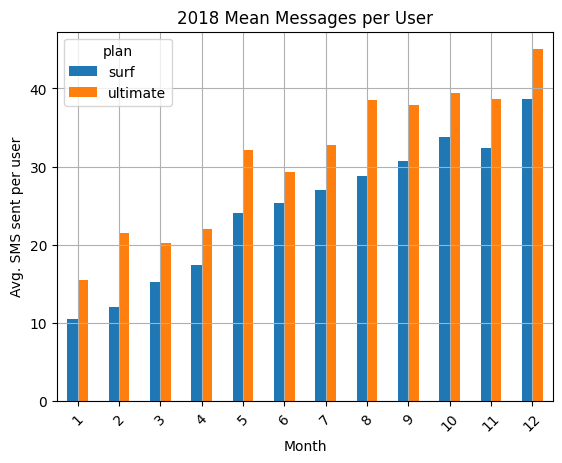

In [46]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
master_df.pivot_table(index='month', columns='plan', values='total_msgs', aggfunc='mean').plot(kind='bar', rot=45)

plt.title('2018 Mean Messages per User')
plt.ylabel('Avg. SMS sent per user')
plt.xlabel('Month')
plt.grid(True)
plt.show()

La cantidad de mensajes promedio tiene una tendencia claramente creciente a lo largo del año para ambos planes.
Esto se puede deber indirectamente al aumento mensual de usuarios, ya que entre más usuarios haya es más probable que algunos de ellos envíen muchos más mensajes, lo cual infla el promedio de mensajes usados.

También se puede deber a que con el tiempo los usuarios se dan cuenta que no usan todos los mensajes que les ofrece su plan y por lo tanto usan más los meses siguientes...

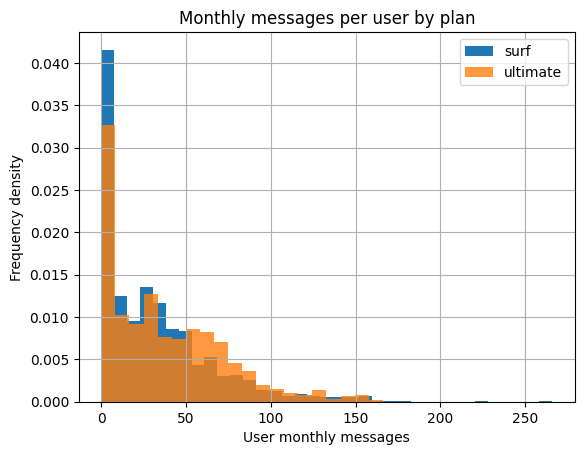

In [47]:
# Compara la cantidad de mensajes consumidos por usuarios por plan
master_df.query("plan=='surf'")['total_msgs'].hist(bins=35, legend=True, density=True)
master_df.query("plan=='ultimate'")['total_msgs'].hist(bins=20, alpha=0.8, legend=True, density=True)

plt.legend(['surf', 'ultimate'])
plt.title('Monthly messages per user by plan')
plt.xlabel('User monthly messages')
plt.ylabel('Frequency density')
plt.show()


In [48]:
# Calcula la media y la varianza de los mensajes mensuales por usuario

print('surf:')
print(master_df.query("plan=='surf'")['total_msgs'].describe()[0:3].to_string())
print('var\t', master_df.query("plan=='surf'")['total_msgs'].var())

print('\nultimate:')
print(master_df.query("plan=='ultimate'")['total_msgs'].describe()[0:3].to_string())
print('var\t', master_df.query("plan=='ultimate'")['total_msgs'].var())

surf:
count    1573.000000
mean       31.159568
std        33.566717
var	 1126.7245219504066

ultimate:
count    720.000000
mean      37.551389
std       34.767179
var	 1208.756743548138


In [49]:
# Imprimir valores atípicos más altos
master_df[['user_id','plan', 'total_msgs']].sort_values(by='total_msgs', ascending=False).head()


,user_id,plan,total_msgs
849,1052,surf,266
1955,1381,surf,224
1956,1381,surf,180
1771,1328,surf,168
194,1132,ultimate,166


En términos generales, el consumo mensual de mensajes presenta un **patrón similar entre usuarios de Surf y Ultimate**. Una proporción considerable de usuarios no utiliza los SMS incluidos, y conforme aumenta el número de mensajes enviados, la cantidad de usuarios disminuye rápidamente. En promedio, los usuarios de Surf envían aproximadamente 31 mensajes por mes con una desviación estándar de 33.6, mientras que los de Ultimate registran un promedio de 37.6 mensajes con una desviación estándar de 34.8. Además, se observa una **tendencia creciente a lo largo del año**, posiblemente asociada a que los usuarios toman conciencia de que disponen de SMS sin utilizar y ajustan su comportamiento para aprovecharlos.


Aunque los promedios son cercanos, los histogramas de densidad permiten identificar una diferencia sutil pero relevante: 
- En Surf, donde el límite incluido es de 50 mensajes, se concentra una mayor proporción de usuarios en rangos **por debajo de ese umbral**.
- En Ultimate, con 1000 mensajes incluidos, la distribución muestra un ligero aumento en la proporción de usuarios que **consumen más de 50 mensajes**. Esto sugiere que los usuarios de Ultimate, aunque se mantienen lejos de agotar su cuota, muestran una mayor disposición a un consumo más elevado que los de Surf.

Un aspecto notable es la presencia de **valores atípicos más frecuentes y más extremos en Surf**. El consumo máximo registrado alcanza los 266 mensajes en un mes para un usuario de este plan. Para la empresa, este comportamiento, aunque no muy común, es particularmente rentable, ya que cada mensaje adicional a los 50 incluidos se cobra a 0.03 USD, frente a 0.01 USD en Ultimate. Aunque en términos individuales la factura final de Surf suele mantenerse por debajo de la cuota fija de Ultimate (es decir, el cliente sigue “ahorrando”), la acumulación de múltiples usuarios con consumos extra en esta y otras categorías genera ingresos adicionales significativos para la compañía.  


### Internet

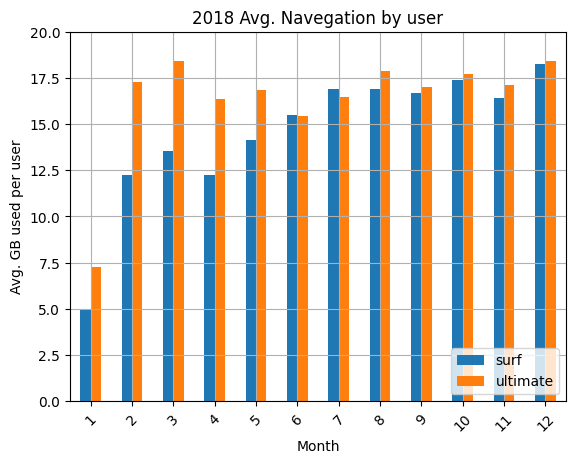

In [50]:
# Compara la cantidad de GB que tienden a usar cada mes los usuarios de cada plan
master_df.pivot_table(index='month', columns='plan', values='total_gb', aggfunc='mean').plot(kind='bar', rot=45)

plt.title('2018 Avg. Navegation by user')
plt.ylabel('Avg. GB used per user')
plt.xlabel('Month')
plt.legend(loc='lower right')
plt.ylim(0,20)
plt.grid(True)
plt.show()

Observaciones:

- Surf tiene una tendencia creciente, mientras que Ultimate tiene una tendencia más estable que se mantiene entre 15 y 18 GB.

- El consumo en enero fue mucho más bajo en ambos casos, esto seguramente se debe a que la cantidad de usuarios fue mucho menor que el resto del año. Y esos pocos usuarios usaron poca navegación.


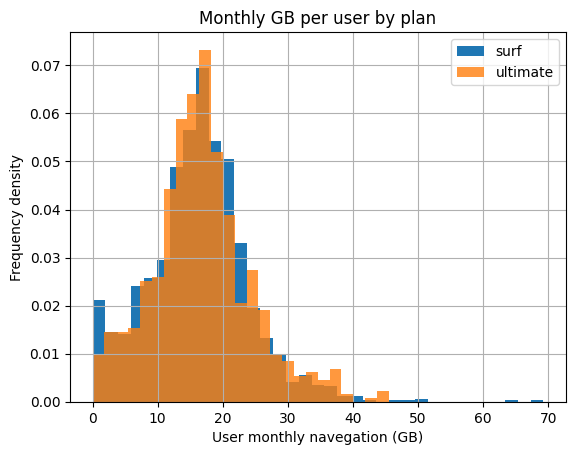

In [51]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
master_df.query("plan=='surf'")['gb_used'].hist(bins=35, legend=True, density=True)
master_df.query("plan=='ultimate'")['gb_used'].hist(bins=25, alpha=0.8, legend=True, density=True)

plt.legend(['surf', 'ultimate'])
plt.title('Monthly GB per user by plan')
plt.xlabel('User monthly navegation (GB)')
plt.ylabel('Frequency density')
plt.show()


In [52]:
# Calcula la media y la varianza de la gigas de navegación mensuales por usuario
print('surf:')
print(master_df.query("plan=='surf'")['total_gb'].describe()[0:3].to_string())
print('var\t', master_df.query("plan=='surf'")['total_gb'].var())

print('\nultimate:')
print(master_df.query("plan=='ultimate'")['total_gb'].describe()[0:3].to_string())
print('var\t', master_df.query("plan=='ultimate'")['total_gb'].var())

surf:
count    1573.000000
mean       16.670693
std         7.847522
var	 61.58359983759012

ultimate:
count    720.000000
mean      17.306944
std        7.670108
var	 58.830549760469786


In [53]:
# Imprimir valores atípicos más altos
master_df[['user_id','plan', 'total_gb']].sort_values(by='total_gb', ascending=False).head()


,user_id,plan,total_gb
1953,1379,surf,70
2272,1121,surf,66
1636,1292,surf,51
1640,1292,surf,51
1464,1240,surf,49


El análisis de la distribución de gigabytes (pagados) muestra un comportamiento de uso bastante similar entre usuarios de ambos planes, con un promedio cercano a 17 GB mensuales y una desviación estándar cercana a 8 GB.

Sin embargo, las implicaciones para la empresa difieren sustancialmente según el plan:

- Ultimate: en su mayoría no alcanzan el límite de 30 GB incluidos. Como consecuencia, generan pocos ingresos adicionales por cargos extra.
- Surf: una gran proporción consume **más de los 15 GB incluidos, incurriendo en cargos por excedente**. Esto es bastante rentable para la empresa ya que el costo por GB excedente es de 10 USD (frente a los 7 USD en Ultimate), y sabemos que la mayor parte de la base de clientes pertenece a este plan.

Como en las categorías anteriores, se observan valores atípicos, sobre todo en Surf. El caso más extremo corresponde a un usuario de Surf con un consumo de 70 GB, lo cual representa una ganancia de 550 USD adicionales. Esta cifra no solo supera ampliamente la tarifa base de Ultimate, sino que también ilustra cómo los excedentes pueden convertirse en una fuente importante de ingresos complementarios para la compañía.

Estos factores pueden ser claves para entender cuál de los dos planes es más rentable al final de cuentas.

## Ingresos

Del mismo modo que estudiamos el comportamiento de los usuarios, ahora veamos las estadísticas de los ingresos que dejan los planes.

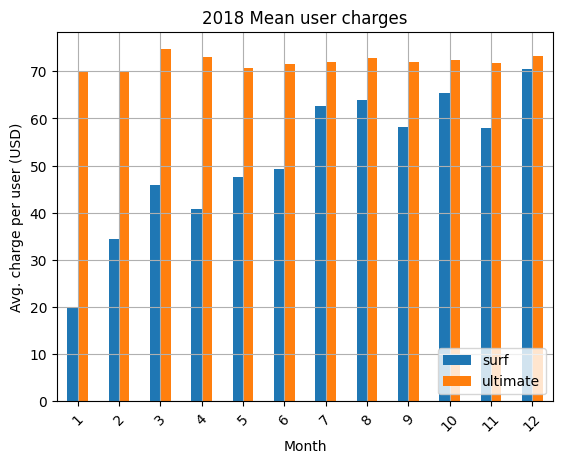

In [54]:
# Compara la cantidad de ingreso promedio por usuario cada mes
master_df.pivot_table(index='month', columns='plan', values='total_charge', aggfunc='mean').plot(kind='bar', rot=45)

plt.title('2018 Mean user charges')
plt.ylabel('Avg. charge per user (USD)')
plt.xlabel('Month')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Observamos que, si bien el promedio de ingreso mensual de Ultimate se mantiene de manera consistente por encima del de Surf, es un ingreso casi fijo en torno a la tarifa base de 70 USD, con variaciones mínimas. Esto refleja que los usuarios de Ultimate generan pocos cargos adicionales y que los ingresos asociados a este plan dependen principalmente de la cuota fija.  

En contraste, los ingresos derivados de Surf presentan una tendencia de crecimiento a lo largo del año. Exceptuando el primer mes —cuando el ingreso promedio coincidió con la tarifa base de 20 USD—, en todos los meses siguientes el promedio ha estado claramente por encima de ese nivel. Hacia finales del año, el ingreso promedio de Surf prácticamente alcanzó al de Ultimate.  

Este comportamiento puede explicarse en parte por el **incremento en la popularidad del plan Surf** frente a Ultimate, que vimos al inicio de esta sección, y por la relación directa entre el **uso de datos móviles y los cargos adicionales**. Es posible que muchos usuarios hayan evaluado que resulta más conveniente contratar Surf y pagar por los gigabytes adicionales consumidos, en lugar de contratar Ultimate.

Además, podemos ver que cualitativamente el crecimiento de ingresos en Surf a lo largo del año se asemeja al crecimiento de uso de GB de navegación. Esto sugiere que los datos de navegación pueden ser el factor principal que influye tanto en las preferencias de los usuarios como en los ingresos adicionales para Megaline.


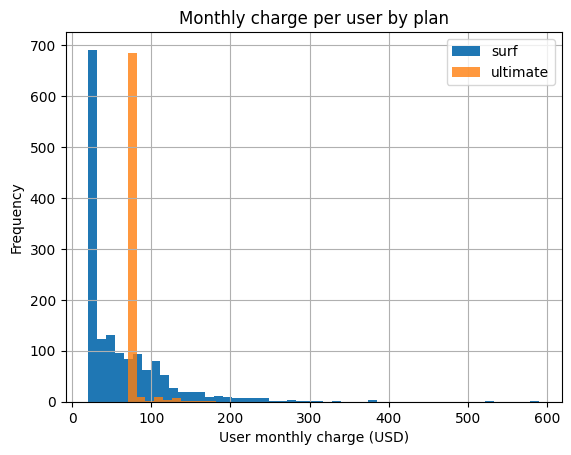

In [55]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
master_df.query("plan=='surf'")['total_charge'].hist(bins=50, legend=True)#, density=True)
master_df.query("plan=='ultimate'")['total_charge'].hist(bins=10, alpha=0.8, legend=True)#, density=True)

plt.legend(['surf', 'ultimate'])
plt.title('Monthly charge per user by plan')
plt.xlabel('User monthly charge (USD)')
plt.ylabel('Frequency')
#plt.ylim(0,0.02)
plt.show()


In [56]:
print('surf:')
print(master_df.query("plan=='surf'")['total_charge'].describe()[0:3].to_string())
print('var\t', master_df.query("plan=='surf'")['total_charge'].var())

print('\nultimate:')
print(master_df.query("plan=='ultimate'")['total_charge'].describe().to_string())
print('var\t', master_df.query("plan=='ultimate'")['total_charge'].var())


surf:
count    1573.000000
mean       60.706408
std        55.388042
var	 3067.835152293878

ultimate:
count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
var	 129.8484855509195


El análisis de las distribuciones de ingresos mensuales muestra diferencias marcadas entre Ultimate y Surf. En promedio por usuario, Ultimate genera más ingresos (70 USD) que Surf (60 USD). Sin embargo, los ingresos de Ultimate están prácticamente anclados a la tarifa base fija, con muy poca variación mensual.

En contraste, Surf presenta una desviación estándar mucho mayor (55 USD vs 11 USD en Ultimate), lo que indica una dispersión más amplia y la presencia de usuarios que generan ingresos adicionales significativos a través de cargos por excedente. A este factor se suma la mayor base de clientes de Surf, lo que magnifica el impacto de estos excedentes en los ingresos totales de la empresa.

Los valores atípicos también juegan un papel importante. En Surf se concentran los casos de facturación excepcionalmente alta debido al consumo intensivo de datos o mensajes, mientras que en Ultimate las facturas se mantienen mucho más estables y predecibles. Este fenómeno convierte a Surf en una fuente de ingresos menos uniforme pero potencialmente más rentable cuando se considera el agregado de toda la base de clientes.

La conclusión sobre cuál plan resulta más rentable no es inmediata. Ultimate garantiza ingresos estables y predecibles por usuario, lo que puede ser valioso desde el punto de vista de la planeación. Surf, en cambio, ofrece una combinación de tarifa base baja, cargos por excedentes altos y una amplia base de clientes, lo que abre la posibilidad de una rentabilidad superior en el agregado, aunque con mayor variabilidad.
Para un análisis más completo de la rentabilidad sería necesario considerar también el costo operativo asociado a prestar cada servicio.

In [57]:
master_df[['plan', 'total_charge']].groupby(['plan']).sum()

,total_charge
plan,
surf,95491.18
ultimate,52066.00


## Prueba las hipótesis estadísticas

Para complementar el análisis directo de los datos, haremos pruebas de hipótesis estadísticas. Primero probemos la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de Ultimate y Surf.

Hipótesis nula ($H_0$): los ingresos promedio mensuales de Ultimate y Surf son iguales.
Hipótesis alternativa ($H_1$): los ingresos promedio mensuales de Ultimate y Surf son iguales. 

Haremos una prueba t de dos colas de Welch, ya que tenemos varianzas muy distintas en ambas distribuciones.
Usaremos un valor de significación estadística de 5%.


In [58]:
from scipy import stats as st

# Prueba las hipótesis
array1 = master_df.query("plan=='surf'")['total_charge']
array2 = master_df.query("plan=='ultimate'")['total_charge']
alpha = 0.05

_, p = st.ttest_ind(array1, array2, equal_var=False)

if p > alpha:
    print("No rechazamos la hipotesis nula")
else:
    print("Rechazamos la hipótesis nula, con un valor p:", p)


Rechazamos la hipótesis nula, con un valor p: 3.1703905481135734e-15


Ahora probamos la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

Hipótesis nula ($H_0$): los ingresos promedio mensuales del área NY-NJ son iguales a los de otras regiones.
Hipótesis alternativa ($H_1$): los ingresos promedio mensuales del área NY-NJ son distintos a los de otras regiones.

Haremos una prueba t de dos colas, con varianzas similares.
Usaremos un valor de significación estadística de 5%.


In [59]:
# Encontramos el valor textual para la región NY-NJ
master_df['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Orlando-Kissimmee-Sanford, FL MSA', 'Cleveland-Elyria, OH MSA',
       'Knoxville, TN MSA', 'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA',
       'Birmingham-Hoover, AL MSA', 'Oklahoma City, OK MSA',
       'Denver-Aurora-Lakewood, CO MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Nashville-Davidson–Murfreesboro–Franklin, TN MSA',
       'Columbus, OH MSA', 'Las Vegas-Henderson-Paradise, NV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA',
       'Miami-Fort Lauderdale-West Palm Beach, FL MSA',
       'Columbia, SC MSA', 'San Antonio-New Braunfels, TX MSA',
       'Charlotte-Concord-Gastonia, NC-SC MSA',
       'Phoenix-Mesa-Chandler, AZ MSA',
       'Riverside-San Bernardino-Ontario, CA MSA',
       'Grand Rapids-Ken

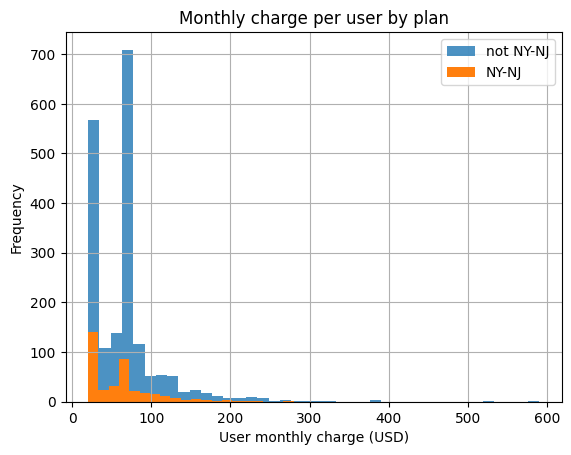

In [60]:
master_df.query("city!='New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_charge'].hist(bins=40, alpha=0.8, legend=True)#, density=True)
master_df.query("city=='New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_charge'].hist(bins=20, legend=True)#, density=True)

#*plt.xscale('log') 
plt.legend(['not NY-NJ', 'NY-NJ'])
plt.title('Monthly charge per user by plan')
plt.xlabel('User monthly charge (USD)')
plt.ylabel('Frequency')
#plt.ylim(0,0.02)
plt.show()

In [64]:
# Prueba las hipótesis
array1 = master_df.query("city=='New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_charge']
array2 = master_df.query("city!='New York-Newark-Jersey City, NY-NJ-PA MSA'")['total_charge']
alpha = 0.05

_, p = st.ttest_ind(array1, array2, equal_var=True)

if p > alpha:
    print("No rechazamos la hipotesis nula")
else:
    print("Rechazamos la hipótesis nula, con un valor p:", p)


Rechazamos la hipótesis nula, con un valor p: 0.04355743162134274


# Conclusión general



Se integraron y limpiaron las tablas `users`, `calls`, `messages`, `internet` y `plans` -correspondietes a la base de datos de las dos tarifas de prepago, Ultimate y Surf, de la empresa Megaline- en un único `master_df. Allí se concentró tanto el consumo mensual de cada usuario como el cálculo de su cargo monetario total (en USD). Durante este proceso se aplicaron las reglas de redondeo de Megaline: llamadas redondeadas al minuto individual y tráfico web redondeado al total mensual en gigabytes.

El análisis combinó estadística descriptiva (medias, desviaciones estándar, outliers), visualizaciones (boxplots, histogramas y gráficos de barras), con el objetivo de comparar el comportamiento de los usuarios de Ultimate y Surf en llamadas, mensajes y datos móviles.
Además, se elaboró una prueba t de Welch de dos colas para comparar ingresos medios entre planes, y una prueba t de dos colas estándar al estudiar diferencias entre regiones (NY–NJ vs el resto). Estas decisiones metodológicas respondieron a la presencia de varianzas desiguales y a la necesidad de confirmar diferencias en los ingresos.

Principales hallazgos:
1. **Llamadas:** consumo promedio similar (~430 min), pero Ultimate genera pocos cargos adicionales mientras que Surf aporta ingresos extra más frecuentes, incluidos outliers notables.  
2. **Mensajes SMS:** uso bajo en ambos planes (Surf ≈31, Ultimate ≈38), con poca relevancia para los ingresos más allá de las tarifas base.  
3. **Datos móviles:** variable decisiva; consumo medio ~17 GB en ambos planes. Con Ultimate rara vez alcanza los 30 GB incluidos, mientras que en Surf muchos usuarios superan los 15 GB base, generando cargos adicionales a un precio mayor (10 USD/GB). Los outliers de Surf aportan ingresos extraordinarios.  
4. **Ingresos:**  
   - Ultimate: estable (~70 USD) y predecible, pero casi sin cargos adicionales.  
   - Surf: menor promedio (~60 USD), mayor dispersión (σ≈55) y base de clientes más amplia, lo que en conjunto lo vuelve más rentable.  
   - En ambos contrastes estadísticos (planes y regiones) se rechazó la hipótesis nula, confirmando diferencias significativas en los ingresos.

En síntesis, **Ultimate asegura estabilidad, pero Surf concentra el potencial de rentabilidad gracias a su mayor base de usuarios, los precios más altos por excedentes y la frecuencia con que estos ocurren**. Los datos móviles se confirman como la categoría clave en la generación de ingresos. Para una evaluación completa de rentabilidad sería necesario incorporar el análisis de costos de prestación del servicio, no solo de ingresos brutos.

Mi recomendación inicial para el departamento comercial sería incrementar la publicidad para surf y mantener un presupuesto moderado para Ultimate, ya que Ultimate puede proveer un ingreso base pero Surf muestra una tendencia a incrementar los ingresos gracias a los cargos extra. 